In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import math
import random
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
df = pd.read_csv('./WineQT.csv')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [4]:
data = []
for i in range(11):
    data.append([])

for index, row in df.iterrows():
    instance = []
    for i in range(11):
        instance.append(row[i])
    data[int(row[11])].append(instance)

In [5]:
for i in range(11):
    random.shuffle(data[i])

In [6]:
def value_to_one_hot(value, num_classes = 11):
    one_hot = [0] * num_classes
    one_hot[value] = 1
    
    return one_hot

In [7]:
train_data = []
valid_data = []
test_data = []

In [8]:
for i in range(11):
    for_valid = for_test = len(data[i]) // 5
    for idx, it in enumerate(data[i]):
        if idx < for_valid:
            valid_data.append({'input': it, 'value': value_to_one_hot(i)})
        elif idx < for_valid + for_test:
            test_data.append({'input': it, 'value': value_to_one_hot(i)})
        else:
            train_data.append({'input': it, 'value': value_to_one_hot(i)})

In [9]:
np.savez('./data.npz', train = train_data, valid = valid_data, test = test_data)

In [2]:
npzfile = np.load('./data.npz', allow_pickle=True)
train_data = npzfile['train']
valid_data = npzfile['valid']
test_data = npzfile['test']

In [3]:
w = np.random.rand(11, 11)
b = np.random.rand(11)

In [4]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def compute_y1(w, x, b):
    z = np.dot(w.T, x) + b
    return np.array(softmax(z))
    
def update(w, x, b, y, lr):
    y1 = compute_y1(w, x, b)
    
    delta_z = y1 - y
    delta_w = np.dot(delta_z, x.T)
    delta_b = delta_z
    
    new_w = w - lr * delta_w
    new_b = b - lr * delta_b
    
    return new_w, new_b

In [5]:
epochs = 2000
lr = 0.07
best_w = w
best_b = b
best_acc = 0.0
metric_val = []

In [6]:
for epoch in tqdm(range(epochs)):
    random.shuffle(train_data)
    for it in train_data:
        x = np.array(it['input'])
        y = np.array(it['value'])
        w, b = update(w, x, b, y, lr)
    
    acc = 0
    for it in valid_data:
        x = np.array(it['input'])
        y = np.array(it['value'])
        y1 = compute_y1(w, x, b)
        
        if y.argmax() == y1.argmax():
            acc += 1
    acc /= len(valid_data)
    metric_val.append(acc)
    
    if acc > best_acc:
        best_acc = acc
        best_w = w
        best_b = b

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 61.17it/s]


In [7]:
print(best_acc)

0.46017699115044247


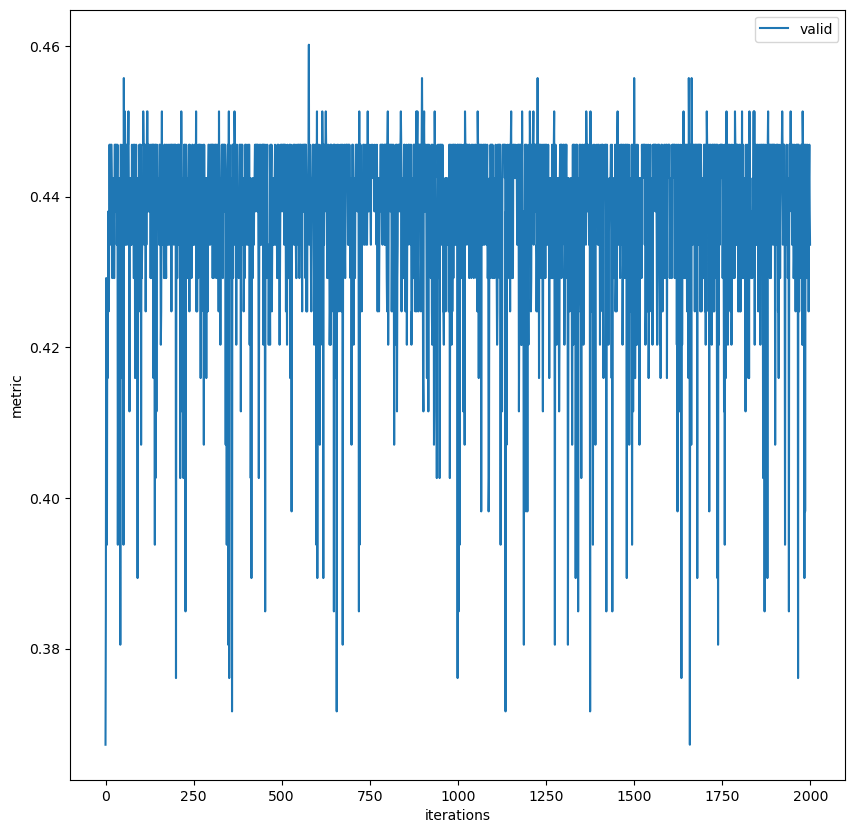

In [8]:
plt.figure(figsize=(10,10))
plt.plot(metric_val, label='valid')
plt.xlabel("iterations")
plt.ylabel('metric')
plt.legend()
plt.show()

In [9]:
acc = 0
for it in test_data:
    x = np.array(it['input'])
    y = np.array(it['value'])
    y1 = compute_y1(best_w, x, best_b)

    if y.argmax() == y1.argmax():
        acc += 1
acc /= len(test_data)
print(acc)

0.4424778761061947


In [10]:
np.savez('./model.npz', w = best_w, b = best_b)